In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek  # Better than SMOTE alone
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from category_encoders import OneHotEncoder

In [2]:
# Load dataset
df = pd.read_csv("soil_heavy_metal_dataset.csv")  # Replace with actual filename


In [3]:
# Check unique soil types and one-hot encoding
unique_soil_types = df['Soil_Type'].unique()
print(f"Unique soil types: {unique_soil_types}")

Unique soil types: ['Loamy' 'Clay' 'Sandy' 'Silt']


In [4]:
# Handle missing values
df.dropna(inplace=True)

In [5]:
# Define features (X) and target (y)
X = df.drop(columns=['Contamination_Level'])  # Adjust column name if needed
y = df['Contamination_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

In [6]:

# Split data (stratify ensures balanced classes in train/test split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [8]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [10]:
# Handle class imbalance with SMOTE-Tomek
smote_tomek = SMOTETomek()
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)


In [11]:
# Further tuning for better minority class performance
xgb = XGBClassifier(
    learning_rate=0.06,  # Lower for stable learning
    max_depth=4,  # Reduce depth to prevent overfitting
    n_estimators=300,  # More trees for improved accuracy
    subsample=0.85,  # Adjusted subsample for better diversity
    colsample_bytree=0.8,  # Helps prevent overfitting
    scale_pos_weight={0: 1, 1: 1, 2: 10},  # Further boosting Class 2
    eval_metric='mlogloss'
)

In [12]:

# Train the model
xgb.fit(X_train_balanced, y_train_balanced)


c:\Users\Samhit\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
# Make predictions
y_pred = xgb.predict(X_test_scaled)

In [14]:

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized XGBoost Accuracy: {accuracy:.3f}\n")
print("Classification Report for Optimized XGBoost:")
print(classification_report(y_test, y_pred))


Optimized XGBoost Accuracy: 0.940

Classification Report for Optimized XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.96      0.96      0.96       163
           2       0.67      0.80      0.73         5

    accuracy                           0.94       200
   macro avg       0.83      0.87      0.85       200
weighted avg       0.94      0.94      0.94       200



In [15]:

# Feature Importance
feature_importance = np.abs(xgb.feature_importances_)
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)


C:\Users\Samhit\AppData\Local\Temp\ipykernel_16860\1631547635.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


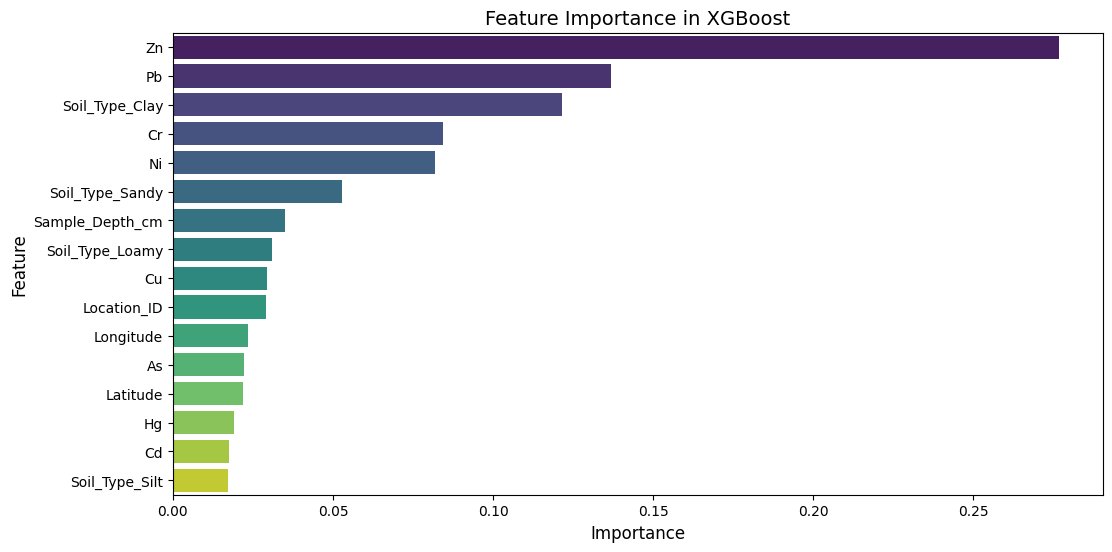

In [16]:
# Plot Feature Importance
plt.figure(figsize=(12,6))
ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance in XGBoost", fontsize=14)
plt.show()


In [19]:
import pickle
import numpy as np

# Load model, scaler, and encoder
model = pickle.load(open("model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
encoder = pickle.load(open("encoder.pkl", "rb"))  # OneHotEncoder for Soil_Type

# Function to predict contamination level
def predict_contamination(nickel, lead, chromium, mercury, cadmium, arsenic, copper, zinc, sample_depth, latitude, longitude, soil_type):
    try:
        # Numeric features
        features = [nickel, lead, chromium, mercury, cadmium, arsenic, copper, zinc, sample_depth, latitude, longitude]

        # Encode Soil Type
        soil_type_encoded = encoder.transform([[soil_type]]).toarray().flatten().tolist()

        # Combine numeric and categorical features
        final_features = features + soil_type_encoded

        # Convert to numpy array and reshape for model input
        input_data = np.array(final_features).reshape(1, -1)

        # Scale the input features
        input_data = scaler.transform(input_data)

        # Make prediction
        prediction = model.predict(input_data)

        print(f"Predicted Contamination Level: {prediction[0]}")

    except Exception as e:
        print(f"Error: {str(e)}")

# Example usage
predict_contamination(10.5, 15.2, 25.8, 0.03, 0.4, 2.1, 18.7, 30.2, 10, 37.7749, -122.4194, "Loamy")


Error: Unexpected input dimension 1, expected 14
